# 13. INTRODUCTION DEEP LEARNING

# 13.4. Overfitting and Underfitting

# 13.4.1. COURS

# Example - Train a Model with Early Stopping

In [1]:
# Chemin des sources
import os
os.chdir('C:/Users/PC Maison/4-KAGGLE/KAGGLE_DEV/KAGGLE_COURS_13-INTRO_DEEP_LEARNING/input')

In [2]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

red_wine = pd.read_csv('red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)
display(df_train.head(4))

# Scale to [0, 1]
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6


# Capacité

In [3]:
# Augmentons maintenant la capacité du réseau. 
# Nous opterons pour un réseau assez important, mais comptons sur le rappel 
# pour arrêter la formation dès que la perte de validation montrera des signes
# d'augmentation.
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[11]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss='mae',
)

Minimum validation loss: 0.09234035760164261


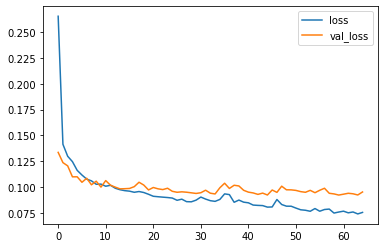

In [4]:
# Entrainement du modèle
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
plt.show()

# 13.4.2. EXERCICES

In [5]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [7]:
spotify = pd.read_csv('spotify.csv')

In [8]:
X = spotify.copy().dropna()

In [9]:
y = X.pop('track_popularity')

In [10]:
artists = X['track_artist']

In [11]:
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

In [12]:
preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

In [13]:
# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

In [14]:
X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

In [15]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

In [16]:
input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


In [19]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])

In [20]:
model.compile(
    optimizer='adam',
    loss='mae',
)

Minimum Validation Loss: 0.1966


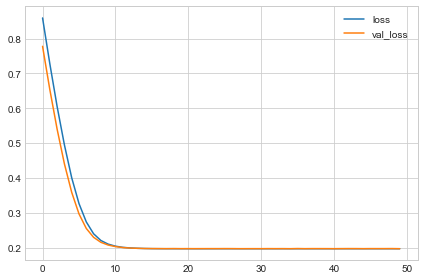

In [18]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Minimum Validation Loss: 0.1966


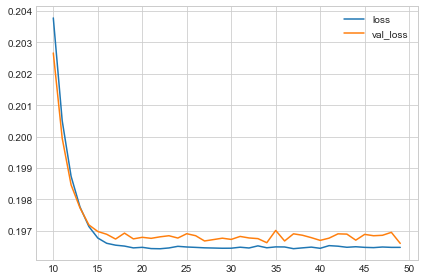

In [21]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 1) Evaluate Baseline

In [22]:
# L'écart entre ces courbes est assez faible et la perte de validation
# n'augmente jamais, il est donc plus probable que le réseau soit sous-équipé 
# que suréquipé. 
# Il serait intéressant d'expérimenter avec une plus grande capacité pour voir
# si c'est le cas.

Epoch 1/50
49/49 [==============================] - 0s 3ms/step - loss: 0.2351 - val_loss: 0.2094
Epoch 2/50
49/49 [==============================] - 0s 1ms/step - loss: 0.2025 - val_loss: 0.2041
Epoch 3/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1975 - val_loss: 0.1999
Epoch 4/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1937 - val_loss: 0.1985
Epoch 5/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1915 - val_loss: 0.1973
Epoch 6/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1895 - val_loss: 0.1970
Epoch 7/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1890 - val_loss: 0.1982
Epoch 8/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1877 - val_loss: 0.1971
Epoch 9/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1863 - val_loss: 0.1963
Epoch 10/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1854 - val_loss: 0.1963
Epoch 11/50
49/49 [

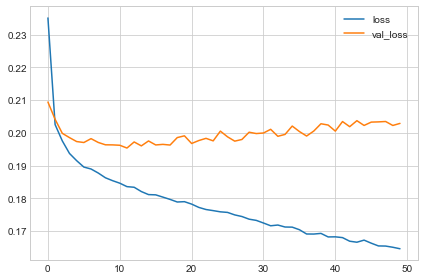

In [23]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 2) Add Capacity

In [ ]:
# Maintenant, la perte de validation commence à augmenter très tôt, tandis que 
# la perte de formation continue à diminuer. Cela indique que le réseau a 
# commencé à se surajuster. À ce stade, il faudrait essayer quelque chose pour 
# l'empêcher, soit en réduisant le nombre d'unités, soit par une méthode comme 
# l'arrêt anticipé. (Nous en verrons une autre dans la prochaine leçon !)

# 3) Define Early Stopping Callback

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Epoch 1/50
49/49 [==============================] - 0s 2ms/step - loss: 0.2697 - val_loss: 0.2087
Epoch 2/50
49/49 [==============================] - 0s 1ms/step - loss: 0.2033 - val_loss: 0.2021
Epoch 3/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1982 - val_loss: 0.2008
Epoch 4/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1949 - val_loss: 0.1989
Epoch 5/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1924 - val_loss: 0.1970
Epoch 6/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1911 - val_loss: 0.1970
Epoch 7/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1893 - val_loss: 0.1963
Epoch 8/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1877 - val_loss: 0.1963
Epoch 9/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1870 - val_loss: 0.1961
Epoch 10/50
49/49 [==============================] - 0s 1ms/step - loss: 0.1861 - val_loss: 0.1962
Minimum Validation 

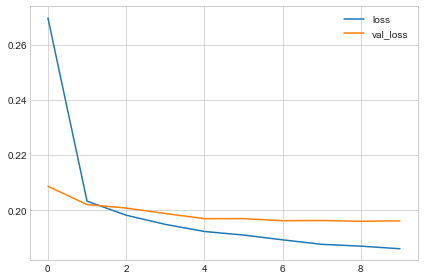

In [25]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 4) Train and Interpret

In [ ]:
# Le rappel d'arrêt anticipé a effectivement mis fin à la formation une fois
# que le réseau a commencé à surcharger. De plus, en incluant les 
# restore_best_weights, nous pouvons toujours conserver le modèle où la perte 
# de validation était la plus faible.